# Implementation of trading strategies based on labels

After checking the trends of weekly prices of PKX stock, I've labeled them green if it has upward trend and red if it had downward trend. Implementation of these strategies were done based from these labels. 



First strategy was buy and hold strategy.
Assume that $100 was invested for the first green labeled week by buying fractional number of shares of stock at the opening price of the first trading day of the week.

If the next week is red there are two options.

1) If this week label is green, sell the shares at the closing price of the last trading day of this week

2) if this week label is red, do nothing and preserve cash for the next week.

If the next week label is green there are two options

1) if this week label is green, do nothing and preserve stock for the next week.

2) if this week label is red, invest all cash to buy fractional number of stock at the opening price of the next week.

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings;
warnings.filterwarnings('ignore');

# Data loading and preprocessing

First, I read the PKX stock data from the csv file that was retrieved by yahoo finance and separated the dataframe into two years 2021 and 2022.
Then, made two new columns “volatility” and “Mean_Return” to examine the distribution of the returns.

In [6]:
train_df = pd.read_csv("PKX.csv")

In [9]:
df_21 = train_df.loc[train_df['Year'] == 2021.0].copy()

In [10]:
df_21["Mean_Return"] = df_21.groupby('Week_Number')['Return'].transform('mean').apply(lambda x: round(x*100,2))

In [11]:
df_21["volatility"] = df_21.groupby('Week_Number')['Return'].transform('std').apply(lambda x: round(x*100,2))

In [22]:
df_21.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Label,Mean_Return,volatility
70,1/4/21,2021.0,1.0,4.0,Monday,1.0,2021-01,63.39,63.69,62.14,62.39,104900.0,62.39,0.001284,61.838571,55.9606,red,1.55,1.95
71,1/5/21,2021.0,1.0,5.0,Tuesday,1.0,2021-01,65.00,65.81,64.82,65.49,101800.0,65.49,0.049687,62.041429,56.3488,red,1.55,1.95
72,1/6/21,2021.0,1.0,6.0,Wednesday,1.0,2021-01,64.99,66.38,64.95,65.89,178100.0,65.89,0.006108,62.255714,56.6928,red,1.55,1.95
73,1/7/21,2021.0,1.0,7.0,Thursday,1.0,2021-01,66.87,67.00,66.57,66.70,77700.0,66.70,0.012293,62.560000,57.0678,red,1.55,1.95
74,1/8/21,2021.0,1.0,8.0,Friday,1.0,2021-01,67.00,67.39,66.50,67.23,67300.0,67.23,0.007946,62.957143,57.4414,green,1.55,1.95


In [13]:
df_22 = train_df.loc[train_df['Year'] == 2022.0].copy()
df_22["Mean_Return"] = df_22.groupby('Week_Number')['Return'].transform('mean').apply(lambda x: round(x*100,2))
df_22["volatility"] = df_22.groupby('Week_Number')['Return'].transform('std').apply(lambda x: round(x*100,2))

# Implementing buy and hold strategy

In order to get the closing price of the last day of the trading week and the opening price of the trading week, I separated the yearly stock price dataframe into two separate dataframes named “df_weekNum_first”, and “df_weekNum_last”.

In [104]:
df_weekNum_last = df_21.drop_duplicates(subset='Week_Number', keep = "last").reset_index()
df_weekNum_first = df_21.drop_duplicates(subset='Week_Number', keep = "first").reset_index()

In [106]:
df_weekNum_last_22 = df_22.drop_duplicates(subset='Week_Number', keep = "last").reset_index()
df_weekNum_first_22 = df_22.drop_duplicates(subset='Week_Number', keep = "first").reset_index()

In [20]:
df_weekNum_first.head()

,index,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Label,Mean_Return,volatility
0,70,1/4/21,2021.0,1.0,4.0,Monday,1.0,2021-01,63.39,63.69,62.14,62.39,104900.0,62.39,0.001284,61.838571,55.9606,red,1.55,1.95
1,75,1/11/21,2021.0,1.0,11.0,Monday,2.0,2021-02,64.30,65.95,63.73,65.62,229400.0,65.62,-0.023948,63.267857,57.8188,green,-1.71,2.58
2,80,1/19/21,2021.0,1.0,19.0,Tuesday,3.0,2021-03,62.15,62.15,61.42,61.67,63800.0,61.67,0.001136,63.952857,59.3622,green,-0.65,1.57
3,84,1/25/21,2021.0,1.0,25.0,Monday,4.0,2021-04,60.32,60.32,59.40,59.75,239100.0,59.75,-0.003835,63.592857,60.0814,red,-1.79,1.03
4,89,2/1/21,2021.0,2.0,1.0,Monday,5.0,2021-05,56.22,56.81,55.91,56.66,119300.0,56.66,0.034130,60.222143,60.3940,green,1.67,2.24


In [21]:
df_weekNum_last.head()

,index,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Label,Mean_Return,volatility
0,74,1/8/21,2021.0,1.0,8.0,Friday,1.0,2021-01,67.00,67.39,66.50,67.23,67300.0,67.23,0.007946,62.957143,57.4414,green,1.55,1.95
1,79,1/15/21,2021.0,1.0,15.0,Friday,2.0,2021-02,62.68,62.68,61.51,61.60,172900.0,61.60,-0.050262,63.945714,59.0972,green,-1.71,2.58
2,83,1/22/21,2021.0,1.0,22.0,Friday,3.0,2021-03,59.26,60.37,59.07,59.98,317000.0,59.98,-0.024715,63.781429,59.9500,red,-0.65,1.57
3,88,1/29/21,2021.0,1.0,29.0,Friday,4.0,2021-04,55.53,55.97,54.56,54.79,194200.0,54.79,-0.018452,60.862143,60.3406,green,-1.79,1.03
4,93,2/5/21,2021.0,2.0,5.0,Friday,5.0,2021-05,59.09,59.65,58.67,59.47,149800.0,59.47,-0.004686,59.014286,60.8166,green,1.67,2.24


As mentioned above, the strategy is based on the initial cash of $100 and fractional number of stock is bought at the very first green labeled week.

After the implementation of buy-and-hold strategy, final amount of cash was 147.934 dollars and was able to make profit of 47.934 dollars .

In [117]:
def buy_hold_strat(first_df, last_df):
    cash = 100
    first_open_price = first_df.loc[(first_df["Label"] == "green") & (first_df["Weekday"] == "Monday")]["Open"].iloc[0]
    num_stock = round(cash / first_open_price,2)
    last_df["Profit"] = np.nan
    for i in range(len(last_df)-1):
        if last_df["Label"].iloc[i+1] == "red":
            if last_df["Label"].iloc[i] == "green":
                cash = num_stock * last_df["Close"].iloc[i]
                profit = (num_stock * last_df["Open"].iloc[i]) - cash
                last_df["Profit"].iloc[i] = profit
            elif last_df["Label"].iloc[i] == "red":
                last_df["Profit"].iloc[i] = 0
        elif last_df["Label"].iloc[i+1] == "green":
            if last_df["Label"].iloc[i] == "red":
                num_stock = (cash / first_df["Open"].iloc[i])
                profit = (num_stock * last_df["Close"].iloc[i]) - cash
                last_df["Profit"].iloc[i] = profit
            elif last_df["Label"].iloc[i] == "green":
                last_df["Profit"].iloc[i] = 0
        elif i+2 == len(last_df):
            cash = num_stock * df_last_df["Close"].iloc[len(last_df)]
    return round(cash,3)

buy_hold_strat(df_weekNum_first,df_weekNum_last)

147.934

# Implementing buy-and-hold strategy based on K-NN classifiers

So the first part of the buy-and-hold strategy was based on labels that were created after checking the plotted trends of stock price. For this case, I will use the K-NN classifier to label the trends for each week using the “Mean_Return” and “volatility” of the stock price. To train the classifier, I used labels from year 1 data and predicted labels for year 2, and implemented the buy-and-hold strategy.

To find the optimal value of k with highest accuracy, I took k = 9 which gave the highest accuracy of 0.82.

In [66]:
X = df_weekNum_last[["Mean_Return","volatility"]].values
y = df_weekNum_last["Label"].to_numpy()

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Accuracy for k =5:",round(ac,2))

Accuracy for k =5: 0.82


Predicting the labels for year 2 by fitting the data into the model.

In [111]:
X = df_weekNum_last_22[["Mean_Return","volatility"]].values
y = df_weekNum_last_22["Label"].to_numpy()
predict_label_22 = knn.predict(X)
predict_label_22
len(predict_label_22)

38

Making a new K-NN predicted label column to the year 2 dataframe

In [113]:
df_weekNum_first_22["KNN_Label"] = predict_label_22
df_weekNum_last_22["KNN_Label"] = predict_label_22

From the predicted labels using K-NN classifier, I implemented buy-and-hold strategy

In [118]:
def buy_hold_strat_KNN(first_df, last_df):
    cash = 100
    first_open_price = first_df.loc[(first_df["KNN_Label"] == "green") & (first_df["Weekday"] == "Monday")]["Open"].iloc[0]
    num_stock = round(cash / first_open_price,2)
    last_df["KNN_Profit"] = np.nan
    for i in range(len(last_df)-1):
        if last_df["KNN_Label"].iloc[i+1] == "red":
            if last_df["KNN_Label"].iloc[i] == "green":
                cash = num_stock * last_df["Close"].iloc[i]
                KNN_Profit = (num_stock * last_df["Open"].iloc[i]) - cash
                last_df["KNN_Profit"].iloc[i] = KNN_Profit
            elif last_df["KNN_Label"].iloc[i] == "red":
                last_df["KNN_Profit"].iloc[i] = 0
        elif last_df["KNN_Label"].iloc[i+1] == "green":
            if last_df["KNN_Label"].iloc[i] == "red":
                num_stock = (cash / first_df["Open"].iloc[i])
                KNN_Profit = (num_stock * last_df["Close"].iloc[i]) - cash
                last_df["KNN_Profit"].iloc[i] = KNN_Profit
            elif last_df["KNN_Label"].iloc[i] == "green":
                last_df["KNN_Profit"].iloc[i] = 0
        elif i+2 == len(last_df):
            cash = num_stock * df_last_df["Close"].iloc[len(last_df)]
    return round(cash,3)
buy_hold_strat_KNN(df_weekNum_first_22, df_weekNum_last_22)


151.842

In [120]:
df_weekNum_last_22.head()

,index,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,...,Volume,Adj Close,Return,Short_MA,Long_MA,Label,Mean_Return,volatility,KNN_Label,KNN_Profit
0,326,1/7/22,2022.0,1.0,7.0,Friday,1.0,2022-01,63.13,63.48,...,229700.0,63.48,0.018124,60.075000,60.1016,red,1.72,0.31,green,-0.595000
1,331,1/14/22,2022.0,1.0,14.0,Friday,2.0,2022-02,63.00,63.09,...,255900.0,62.49,-0.022830,61.460714,60.1072,green,-0.30,1.75,red,0.000000
2,335,1/21/22,2022.0,1.0,21.0,Friday,3.0,2022-03,59.19,59.22,...,252400.0,57.92,-0.023436,61.471429,59.9288,green,-1.84,3.32,red,0.000000
3,340,1/28/22,2022.0,1.0,28.0,Friday,4.0,2022-04,54.98,55.45,...,180100.0,55.18,0.010993,59.490714,59.5502,red,-0.96,1.33,red,0.000000
4,345,2/4/22,2022.0,2.0,4.0,Friday,5.0,2022-05,55.65,56.08,...,195700.0,55.98,0.005930,56.926429,59.3436,red,0.30,1.84,red,1.346754


Trading with predicted labels using K-NN classifier resulted in a larger amount of profit than labeling by me.

# Implementing buy-and-hold strategy based on Logistic Regression


After predicting labels for year2 with K-NN classifiers, I checked if buy-and-hold strategy implementation using logistic regression predicted classifier would give me more profit.

I made the logistic regression model and fit year 1 stock data to train the model. Accuracy of the logistic regression model gave 0.73.

In [126]:
X = df_weekNum_last[["Mean_Return","volatility"]].values
y = df_weekNum_last["Label"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
round(acc, 2)

0.73

These are the predicted labels using logistic regression model trained from the year 1 data.

In [128]:
X = df_weekNum_last_22[["Mean_Return","volatility"]].values
y = df_weekNum_last_22["Label"].to_numpy()
predict_log_label_22 = logreg.predict(X)
predict_log_label_22

array(['green', 'red', 'red', 'red', 'green', 'green', 'red', 'green',
       'red', 'red', 'green', 'green', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'green', 'green', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'green', 'green', 'red', 'green', 'red', 'red',
       'red', 'red', 'red', 'red'], dtype=object)

Made new column “Logistic Label” and put in the predicted labels of year 2 to implement buy-and-hold strategy.

In [129]:
df_weekNum_first_22["Logistic_Label"] = predict_log_label_22
df_weekNum_last_22["Logistic_Label"] = predict_log_label_22

After implementing buy-and-hold strategy based on predicted labels using logistic regression, the profit was slightly less but mostly similar to the profit after using K-NN classifiers.

In [131]:
def buy_hold_strat_log(first_df, last_df):
    cash = 100
    first_open_price = first_df.loc[(first_df["Logistic_Label"] == "green") & (first_df["Weekday"] == "Monday")]["Open"].iloc[0]
    num_stock = round(cash / first_open_price,2)
    last_df["Log_Profit"] = np.nan
    for i in range(len(last_df)-1):
        if last_df["Logistic_Label"].iloc[i+1] == "red":
            if last_df["Logistic_Label"].iloc[i] == "green":
                cash = num_stock * last_df["Close"].iloc[i]
                Log_Profit = (num_stock * last_df["Open"].iloc[i]) - cash
                last_df["Log_Profit"].iloc[i] = Log_Profit
            elif last_df["Logistic_Label"].iloc[i] == "red":
                last_df["Log_Profit"].iloc[i] = 0
        elif last_df["Logistic_Label"].iloc[i+1] == "green":
            if last_df["Logistic_Label"].iloc[i] == "red":
                num_stock = (cash / first_df["Open"].iloc[i])
                Log_Profit = (num_stock * last_df["Close"].iloc[i]) - cash
                last_df["Log_Profit"].iloc[i] = Log_Profit
            elif last_df["Logistic_Label"].iloc[i] == "green":
                last_df["Log_Profit"].iloc[i] = 0
        elif i+2 == len(last_df):
            cash = num_stock * df_last_df["Close"].iloc[len(last_df)]
    return round(cash,3)

buy_hold_strat_log(df_weekNum_first_22, df_weekNum_last_22)


151.633

# Implementing Overnight-Inertia strategy

Second strategy that I implemented is named overnight inertia strategy.
It assumes that the stock has inertia to move to the same direction overnight as it did during the day. 
Therefore, I will trade just before the market closes and hold the position overnight assuming that I know the closing price for the day before the market closes.

Here is my strategy in detail.


1)	If the closing price of today is higher than the opening price of today, the stock increased in price and assume that there still will be upward inertia till the tomorrow opening price. So I buy 100 dollars’ worth of share at the closing price of today and sell the same number of shares at the opening price of tomorrow to end my long position. Then the profit or loss per share will be calculated by opening price(tomorrow) – closing price (today).


2)	If the closing price of today is lower than the opening price of today the stock has downward inertia till tomorrow. Therefore, I will sell 100 dollars’ worth of shares at the closing price of today and buy this same number of shares at the opening price tomorrow to close my short position. Then the profit or loss per share will be calculated by closing price(today) – closing price(tomorrow).


3)	If the closing price of today equals the opening price of today there will be no trade.


In [36]:
conditions = [df_21['Close'] > df_21['Open'], df_21['Close'] < df_21['Open']]
choices = ["Positive", "Negative"]
df_21['Daily_Changes'] = np.select(conditions, choices, default=np.nan)
df_21["Profit"] = np.nan

First, based on the strategy I labeled daily changes of the stock price and made a new column "Daily_Changes"

In [37]:
df_21.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,...,Volume,Adj Close,Return,Short_MA,Long_MA,Label,Mean_Return,volatility,Daily_Changes,Profit
70,1/4/21,2021.0,1.0,4.0,Monday,1.0,2021-01,63.39,63.69,62.14,...,104900.0,62.39,0.001284,61.838571,55.9606,red,1.55,1.95,Negative,NaN
71,1/5/21,2021.0,1.0,5.0,Tuesday,1.0,2021-01,65.00,65.81,64.82,...,101800.0,65.49,0.049687,62.041429,56.3488,red,1.55,1.95,Positive,NaN
72,1/6/21,2021.0,1.0,6.0,Wednesday,1.0,2021-01,64.99,66.38,64.95,...,178100.0,65.89,0.006108,62.255714,56.6928,red,1.55,1.95,Positive,NaN
73,1/7/21,2021.0,1.0,7.0,Thursday,1.0,2021-01,66.87,67.00,66.57,...,77700.0,66.70,0.012293,62.560000,57.0678,red,1.55,1.95,Negative,NaN
74,1/8/21,2021.0,1.0,8.0,Friday,1.0,2021-01,67.00,67.39,66.50,...,67300.0,67.23,0.007946,62.957143,57.4414,green,1.55,1.95,Positive,NaN


In [41]:
df_21_copy = df_21.copy()

In [42]:
def overnight_strat(df):
    cash = 100
    stock_num = 0
    for i in range(len(df)-1):
        if df["Daily_Changes"].iloc[i] == "Positive":
            stock_num += cash / df["Close"].iloc[i]
            cash = 0 
            profit = (stock_num *df["Open"].iloc[i+1]) - (stock_num *df["Close"].iloc[i])
            cash += stock_num *df["Open"].iloc[i+1]
            stock_num = 0
            df["Profit"].iloc[i] = profit
        elif df["Daily_Changes"].iloc[i] == "Negative":
            cash += stock_num * df["Close"].iloc[i]
            stock_num = 0    
            stock_num += cash / df["Open"].iloc[i+1]
            cash = 0
            profit = (stock_num * df["Close"].iloc[i]) - (stock_num *df["Open"].iloc[i+1])
            df["Profit"].iloc[i] = profit

In [64]:
overnight_strat(df_21_copy)
df_21_copy.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,...,Volume,Adj Close,Return,Short_MA,Long_MA,Label,Mean_Return,volatility,Daily_Changes,Profit
70,1/4/21,2021.0,1.0,4.0,Monday,1.0,2021-01,63.39,63.69,62.14,...,104900.0,62.39,0.001284,61.838571,55.9606,red,1.55,1.95,Negative,-4.015385
71,1/5/21,2021.0,1.0,5.0,Tuesday,1.0,2021-01,65.00,65.81,64.82,...,101800.0,65.49,0.049687,62.041429,56.3488,red,1.55,1.95,Positive,-0.769231
72,1/6/21,2021.0,1.0,6.0,Wednesday,1.0,2021-01,64.99,66.38,64.95,...,178100.0,65.89,0.006108,62.255714,56.6928,red,1.55,1.95,Positive,1.487099
73,1/7/21,2021.0,1.0,7.0,Thursday,1.0,2021-01,66.87,67.00,66.57,...,77700.0,66.70,0.012293,62.560000,57.0678,red,1.55,1.95,Negative,-0.454351
74,1/8/21,2021.0,1.0,8.0,Friday,1.0,2021-01,67.00,67.39,66.50,...,67300.0,67.23,0.007946,62.957143,57.4414,green,1.55,1.95,Positive,-4.437494


After computing the profit, I calculated average nightly profit for the PKX stock.

In [45]:
round(df_21["Profit"].mean(skipna = True),2)

-0.05

I wanted to see which position (long, short) gives me more profit.

Both long and short position gave me loss but long position resulted in less loss

In [46]:
long_profit = df_21["Profit"][df_21["Daily_Changes"] == "Positive"].sum()
short_profit = df_21["Profit"][df_21["Daily_Changes"] == "Negative"].sum()

In [47]:
long_profit

-2.017597324562729

In [48]:
short_profit

-10.058164415198661

Then I added restriction of absolute value of percentage threshold of daily returns to see if the restriction will give more profit. For instance, if stock prices rise or fall by more than 3 % I will not trade. 

By taking 100 points from 0 to 10 percent and plotting the mean of profit for each percentage threshold, I found that the absolute value of 2 % threshold was the most profitable.

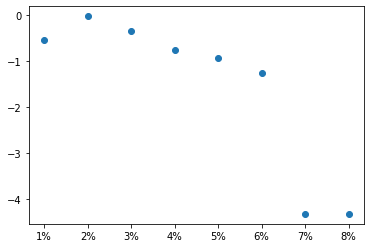

In [51]:
one_per = df_21.loc[abs(df_21["Return"]) > 0.01]["Profit"][:10].mean()
two_per = df_21.loc[abs(df_21["Return"]) > 0.02]["Profit"][:10].mean()
three_per = df_21.loc[abs(df_21["Return"]) > 0.03]["Profit"][:10].mean()
four_per = df_21.loc[abs(df_21["Return"]) > 0.04]["Profit"][:10].mean()
five_per = df_21.loc[abs(df_21["Return"]) > 0.05]["Profit"][:10].mean()
six_per = df_21.loc[abs(df_21["Return"])> 0.06]["Profit"][:10].mean()
seven_per = df_21.loc[abs(df_21["Return"]) > 0.07]["Profit"][:10].mean()
eight_per = df_21.loc[abs(df_21["Return"]) > 0.08]["Profit"][:10].mean()
nine_per = df_21.loc[abs(df_21["Return"]) > 0.09]["Profit"][:10].mean()
ten_per= df_21.loc[abs(df_21["Return"]) > 0.1]["Profit"][:10].mean()
profit_return_per = [one_per, two_per, three_per, four_per,five_per,six_per,seven_per,eight_per, nine_per,ten_per]

percentages = ["1%","2%","3%","4%","5%","6%","7%","8%","9%","10%"]

plt.scatter(percentages,profit_return_per)
plt.show()

# Conclusion

After implementing buy-and-hold, and overnight inertia strategy I plotted the growth of my stock portfolio

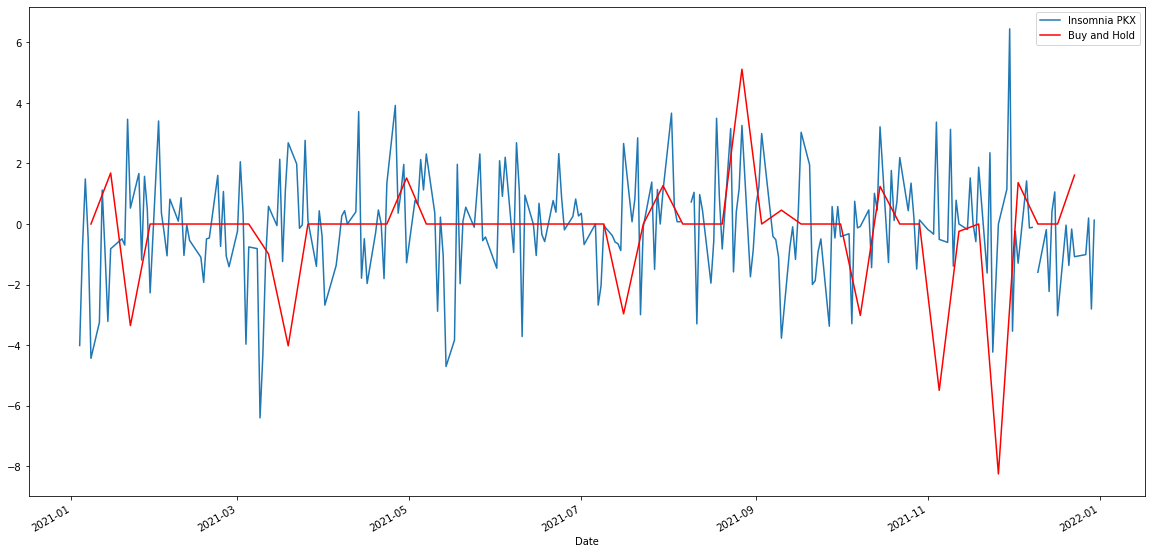

In [61]:
buy_hold_df = df_weekNum_last.copy()

plt.rcParams["figure.figsize"]=(20,10)
axes = plt.gca()
df_21["Date"] = pd.to_datetime(df_21["Date"])
buy_hold_df["Date"] = pd.to_datetime(buy_hold_df["Date"])
df_21.plot(kind='line', x='Date', y='Profit', ax=axes, label = "Insomnia PKX");
buy_hold_df.plot(kind='line', x='Date', y='Profit', ax=axes, label = "Buy and Hold", color = "red")
plt.show()

After implementing both the buy-and-hold and overnight-inertia strategies, I found that buy-and-hold gave more profit. 


The buy-and-hold strategy was based on the weekly labels after examining all the trend plots from the given stock data, and the overnight-inertia strategy was based on the daily opening and closing price of the stock data. 

It showed the significance of human intuition when checking the trend of the stock price. However, since the stock price is not predictable when one tries to make a profit out of trading stocks, the strategy should be flexible based on the trends of the price.